In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

In [30]:
PATH_DATA = './'
MODEL_PATH = "model.pkl"

In [31]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [32]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    
    joblib.dump(clf, MODEL_PATH)
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [33]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

# простые фичи

In [34]:
tqdm_notebook.pandas(desc="Progress")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [35]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [01:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.620+-0.011, Trees: 37


In [36]:
# Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [01:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


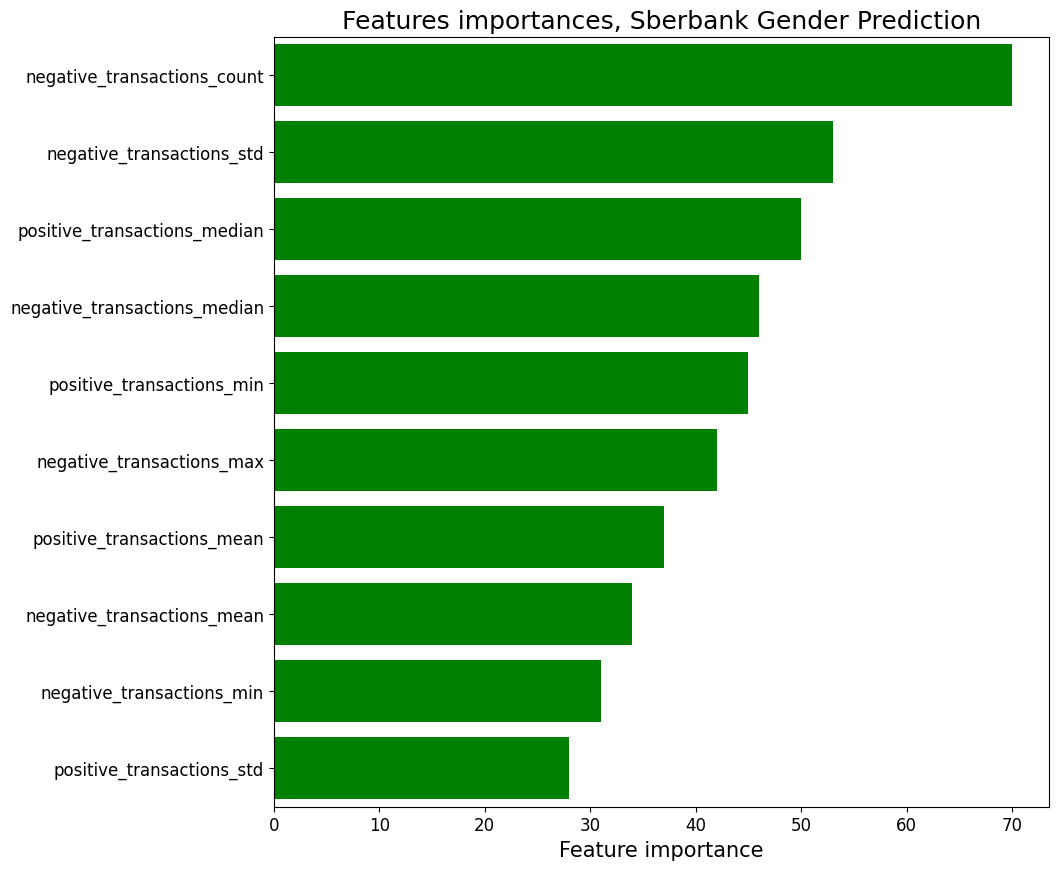

In [37]:
draw_feature_importances(clf, 10)

In [38]:
# Сохраняем результат моделирования

submission.to_csv('basic_features_submission.csv')

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [81]:
transactions.head(1)

,trans_time,mcc_code,trans_type,amount,term_id,trans_city
client_id,,,,,,
d1bbbc9a0e0410d3cf12a3d2f44f3450,35 08:24:41,4829,2370,-1808.56,NaN,Tver


In [39]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [40]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

In [41]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [42]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [01:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.681+-0.011, Trees: 68


In [43]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [01:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


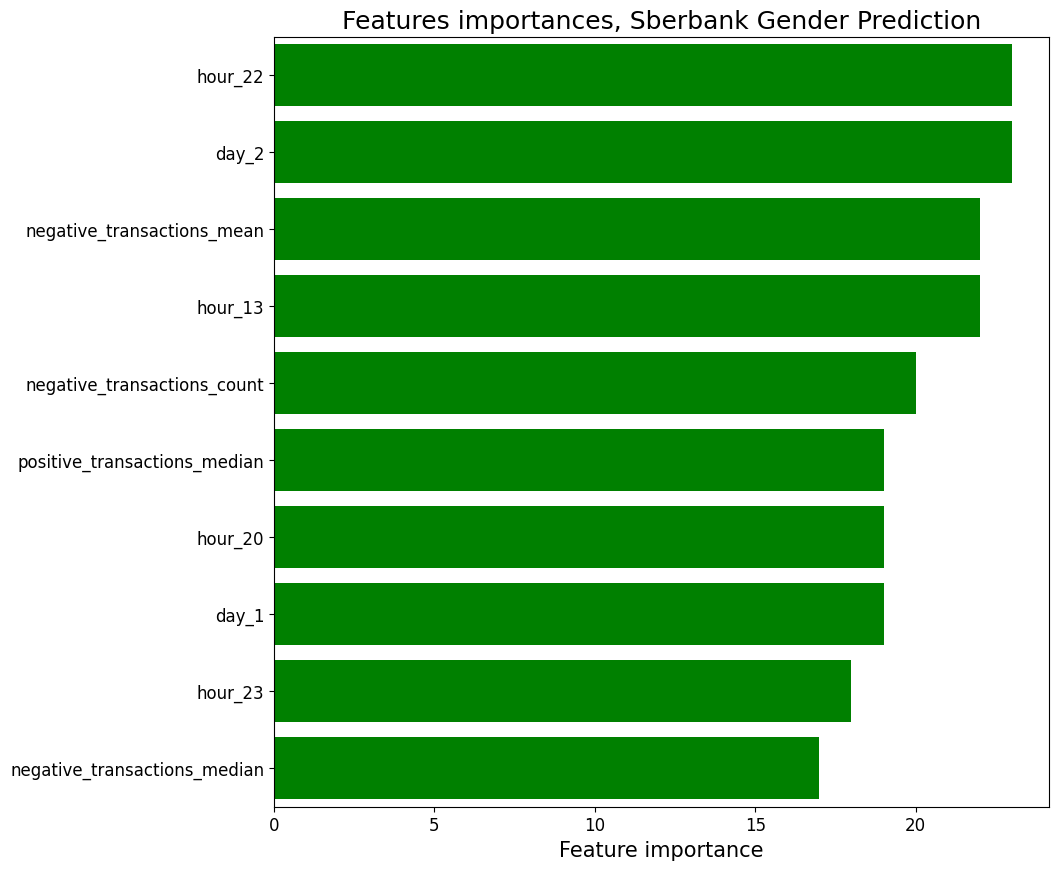

In [44]:
draw_feature_importances(clf, 10)

# транзакции по типам

In [61]:
def features_creation_by_trans_type(x): 
    features = {}
    features.update(x['day'].value_counts(normalize=True).add_prefix('day_').to_dict())
    features.update(x['hour'].value_counts(normalize=True).add_prefix('hour_').to_dict())
    features.update(x['night'].value_counts(normalize=True).add_prefix('night_').to_dict())
    features.update(x[x['amount'] > 0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                       .add_prefix('positive_transactions_').to_dict())
    features.update(x[x['amount'] < 0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                       .add_prefix('negative_transactions_').to_dict())

    for trans_type in x['trans_type'].unique():
        trans_type_data = x[x['trans_type'] == trans_type]['amount']
        features.update(trans_type_data.agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                         .add_prefix(f'{trans_type}_').to_dict())
        
    for trans_type in x['mcc_code'].unique():
        trans_type_data = x[x['mcc_code'] == trans_type]['amount']
        features.update(trans_type_data.agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                         .add_prefix(f'{trans_type}_').to_dict())

    return pd.Series(features)


In [62]:
data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_by_trans_type)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_by_trans_type)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [64]:
data_train_df = data_train.unstack()
data_test_df = data_test.unstack()

In [82]:
cols = data_test_df.columns.to_list()

In [83]:
target = data_train_df.join(gender_train, how='inner')['gender']
cv_score(params, data_train_df[cols], target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [02:14:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.872+-0.003, Trees: 178


In [85]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 178, data_train_df[cols], data_test_df, target)

C:\Users\MSI Prestige\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [02:17:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


In [87]:
submission.to_csv('advanced_features_submission.csv')

In [88]:
joblib.dump(clf, 'xgb_agg_feats.pkl')

['xgb_agg_feats.pkl']